# Chapman-Richards and Näslund models on Laeva data

This program runs the nlme models on the dataset of the Laeva managed forest.

Author: Steffen M. Noe (steffen.noe@emu.ee)

In [1]:
# Nonlinear mixed model with a subset of Laeva managed forest data
#
# I used Andres data, just saved as csv to be sure to read it well into Jupyter notebook
# The notebook is running an R kernel and uses nlme package plus some stuff to make plots

In [2]:
#setwd("/Users/steffen/Desktop/nlme-test/")

In [3]:
# read the data into a dataframe

din <- read.csv("HDLaevaND75_2020.csv")

names(din)[10]<-"D"
names(din)[12]<-"H"
names(din)[9]<-"Species"
head(din)

prt,aasta,kord,kkt,r1,a,puu,rin,Species,D,d2,H,markused
304,2020,6,ND,15,85,59,1,KS,42.4,42.6,32.2,h?
304,2020,6,ND,15,85,40,1,KS,39.9,39.9,31.3,
304,2020,6,ND,15,85,61,2,KU,31.5,29.7,22.0,
304,2020,6,ND,15,85,77,1,KS,31.8,30.5,32.6,
304,2020,6,ND,15,85,82,2,SA,27.3,28.8,23.8,
304,2020,6,ND,15,85,54,2,KU,8.3,7.7,7.5,


In [68]:
#library(tidyverse)
library(dplyr)

library(ggplot2)
theme_set(
  theme_light() # + theme(legend.position = "top")
  )

In [5]:
# this works with dplyr. 

din <- din %>%
    mutate(Species = ifelse(as.character(Species) == "KU", "NS", as.character(Species))) %>%   # KU kuusk      Norway Speciesruce
    mutate(Species = ifelse(as.character(Species) == "KS", "BI", as.character(Species))) %>%   # KS kask       Birch
    mutate(Species = ifelse(as.character(Species) == "MA", "SP", as.character(Species))) %>%   # MA mänd       Scots Pine
    mutate(Species = ifelse(as.character(Species) == "HB", "CA", as.character(Species))) %>%   # HB haab       Common aspen
    mutate(Species = ifelse(as.character(Species) == "PN", "LI", as.character(Species))) %>%   # PN pärn       Lime
    mutate(Species = ifelse(as.character(Species) == "LM", "BAR", as.character(Species))) %>%  # LM must lepp  Black alder
    mutate(Species = ifelse(as.character(Species) == "VA", "NOM", as.character(Species))) %>%  # VA vaher      Norway Maple
    mutate(Species = ifelse(as.character(Species) == "LV", "GAR", as.character(Species)))      # LV valge lepp Gray alder  

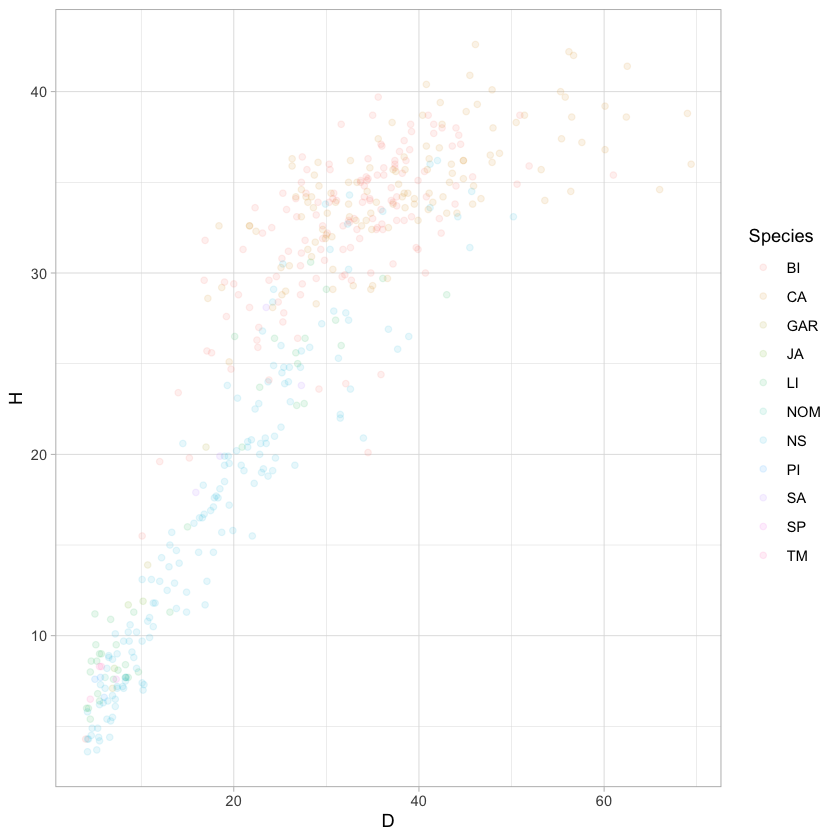

In [6]:
# Let's have a look at them

ggplot(din, aes(x=D, y=H, color=Species))+geom_point(alpha=0.1)

In [7]:
# I use only some of the species here

data <- subset(din,  Species=='BI' | Species=='NS' | Species=='CA' | Species=='LI' | Species=='GAR') 

#for Andres check
#data <- subset(din,  Species=='KS' | Species=='KU' | Species=='HB' | Species=='PN') 

In [67]:
library(nlme)

In [9]:
#make a grouped dataframe

data1 = groupedData(H ~ D | Species, data)

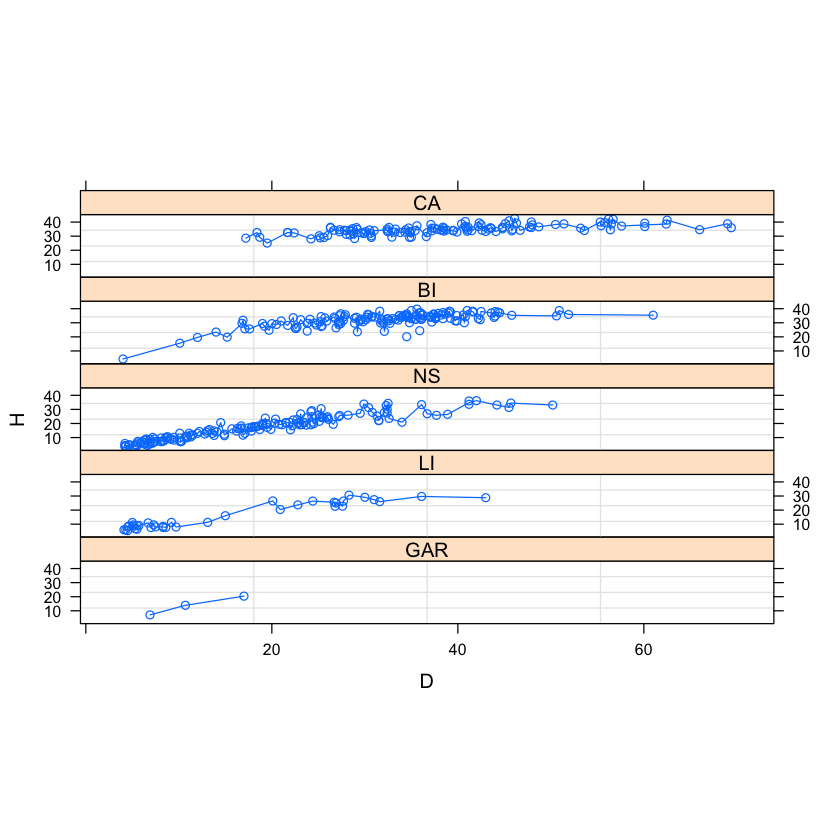

In [10]:
plot(data1)

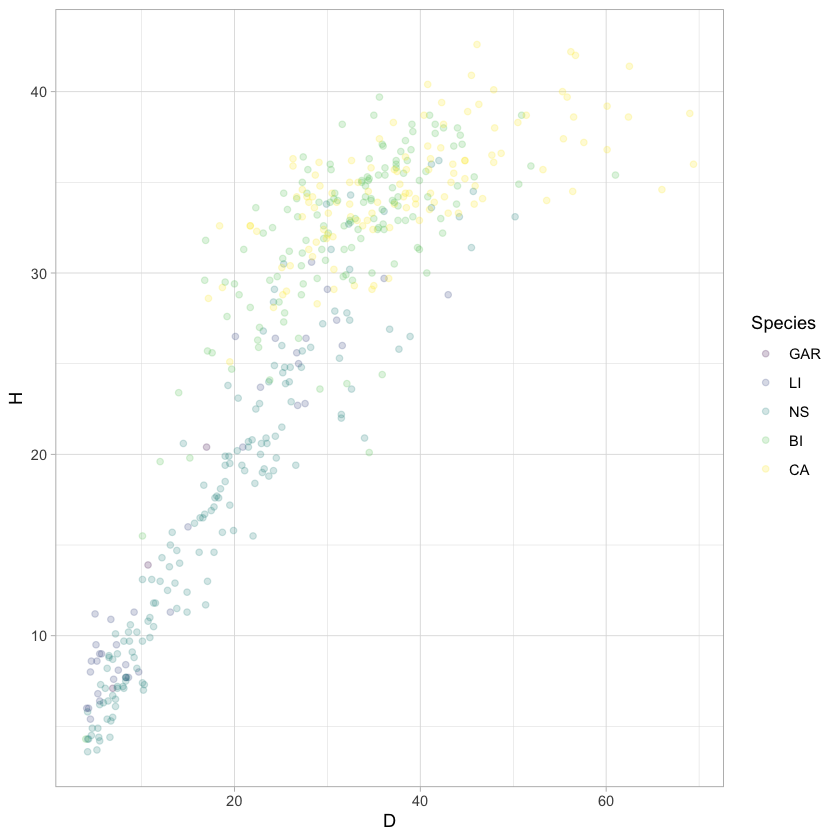

In [11]:
ggplot(data1, aes(x=D, y=H, color=Species))+geom_point(alpha=0.2)

## Chapman model

Here the model 

$$
H = 1.3 + h_{mx} (1 - e^{-k D})^p
$$

with $h_{mx} = a, k = b$ and $p = c$ is defined.

In [12]:
# here I set up a fixed effects model (chapman with fixed intercept)
#
fm1 = nlsList(H ~ 1.3 + a*(1 - exp(-b * D))^c, data=data1, start=list(a=50., b=0.1, c=2.5))

Warning message:
“2 errors caught in nls(model, data = data, control = controlvals, start = start).  The error messages and their frequencies are

Missing value or an infinity produced when evaluating the model 
                                                              1 
                    number of iterations exceeded maximum of 50 
                                                              1 ”

In [13]:
fm1

Call:
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c | Species 
   Data: data1 

Coefficients:
           a          b        c
GAR       NA         NA       NA
LI  36.17236 0.04548278 1.184338
NS  40.24748 0.04260815 1.442579
BI  35.12585 0.08584596 1.460759
CA        NA         NA       NA

Degrees of freedom: 335 total; 326 residual
Residual standard error: 2.742388

In [14]:
# Ok, the Birch problem again! It found parameters for all but Birch.

In [15]:
summary(fm1)

Call:
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c | Species 
   Data: data1 

Coefficients:
   a 
    Estimate Std. Error   t value     Pr(>|t|)
GAR       NA         NA        NA           NA
LI  36.17236  8.0929674  4.469604 9.926059e-06
NS  40.24748  3.9127272 10.286299 3.419313e-21
BI  35.12585  0.9208827 38.143677 4.880875e-70
CA        NA         NA        NA           NA
   b 
      Estimate  Std. Error  t value     Pr(>|t|)
GAR         NA          NA       NA           NA
LI  0.04548278 0.023911954 1.902094 3.485965e-02
NS  0.04260815 0.008698784 4.898173 4.916594e-07
BI  0.08584596 0.016084266 5.337263 3.208671e-06
CA          NA          NA       NA           NA
   c 
    Estimate Std. Error  t value     Pr(>|t|)
GAR       NA         NA       NA           NA
LI  1.184338  0.2621008 4.518634 8.362036e-06
NS  1.442579  0.1569090 9.193734 4.604341e-18
BI  1.460759  0.3927224 3.719572 9.308311e-04
CA        NA         NA       NA           NA

Residual standard error: 2.742388 on 3

In [16]:
# This is the summary for the fixed effect model. We can see that we do not get the 
# Birch parameters estimated. In the rest, we get good results. 

In [17]:
# now I set up a nonlinear mixed model with a fixed part and a random part.
# the random part is in this case the exponent which is allowed to be influenced by the 
# species. 

model1a=nlme(fm1,data1, fixed=list(a~1,b~1,c~1), random=a~1|Species)
model1b=nlme(fm1,data1, fixed=list(a~1,b~1,c~1), random=b~1|Species)
model1c=nlme(fm1,data1, fixed=list(a~1,b~1,c~1), random=c~1|Species)

Warning message in nlme.nlsList(fm1, data1, fixed = list(a ~ 1, b ~ 1, c ~ 1), random = a ~ :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”Warning message in nlme.nlsList(fm1, data1, fixed = list(a ~ 1, b ~ 1, c ~ 1), random = b ~ :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”Warning message in nlme.nlsList(fm1, data1, fixed = list(a ~ 1, b ~ 1, c ~ 1), random = c ~ :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”

### The output of models not show in the Article is supressed

In [18]:
model1a
#model1b
#model1c

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c 
  Data: data1 
  Log-likelihood: -1145.169
  Fixed: list(a ~ 1, b ~ 1, c ~ 1) 
          a           b           c 
32.95649965  0.08451189  1.89821547 

Random effects:
 Formula: a ~ 1 | Species
               a Residual
StdDev: 3.557515 2.875505

Number of Observations: 459
Number of Groups: 5 

In [19]:
summary(model1a)
#summary(model1b)
#summary(model1c)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c 
 Data: data1 
       AIC      BIC    logLik
  2300.338 2320.983 -1145.169

Random effects:
 Formula: a ~ 1 | Species
               a Residual
StdDev: 3.557515 2.875505

Fixed effects: list(a ~ 1, b ~ 1, c ~ 1) 
     Value Std.Error  DF  t-value p-value
a 32.95650 1.7769066 452 18.54712       0
b  0.08451 0.0053529 452 15.78815       0
c  1.89822 0.1433627 452 13.24065       0
 Correlation: 
  a      b     
b -0.235       
c -0.151  0.909

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-4.8526671 -0.6116359 -0.1078323  0.5703921  3.0817263 

Number of Observations: 459
Number of Groups: 5 

In [20]:
# Here the summary of the mixed model with paramter c as random to the species.
# The general model get all parameters estimated.

In [21]:
# now setting up the nlme for one fixed and two random parameters

model2ab=nlme(fm1,data1, fixed=a + b + c ~ 1, random=pdDiag(a + b ~1), groups= ~ Species)
model2ac=nlme(fm1,data1, fixed=a + b + c ~ 1, random=pdDiag(a + c ~1), groups= ~ Species)
model2bc=nlme(fm1,data1, fixed=a + b + c ~ 1, random=pdDiag(b + c ~1), groups= ~ Species)

Warning message in nlme.nlsList(fm1, data1, fixed = a + b + c ~ 1, random = pdDiag(a + :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”Warning message in nlme.nlsList(fm1, data1, fixed = a + b + c ~ 1, random = pdDiag(a + :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”Warning message in nlme.nlsList(fm1, data1, fixed = a + b + c ~ 1, random = pdDiag(b + :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”

In [22]:
#model2ab
model2ac
#model2bc

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c 
  Data: data1 
  Log-likelihood: -1110.425
  Fixed: list(a ~ 1, b ~ 1, c ~ 1) 
          a           b           c 
38.42556811  0.04568429  1.06962595 

Random effects:
 Formula: list(a ~ 1, c ~ 1)
 Level: Species
 Structure: Diagonal
                   a         c Residual
StdDev: 0.0004392143 0.3221767  2.65895

Number of Observations: 459
Number of Groups: 5 

In [23]:
#summary(model2ab)
summary(model2ac)
#summary(model2bc)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c 
 Data: data1 
      AIC      BIC    logLik
  2232.85 2257.624 -1110.425

Random effects:
 Formula: list(a ~ 1, c ~ 1)
 Level: Species
 Structure: Diagonal
                   a         c Residual
StdDev: 0.0004392143 0.3221767  2.65895

Fixed effects: list(a ~ 1, b ~ 1, c ~ 1) 
     Value Std.Error  DF  t-value p-value
a 38.42557 0.6471571 452 59.37595       0
b  0.04568 0.0030462 452 14.99715       0
c  1.06963 0.1569679 452  6.81430       0
 Correlation: 
  a      b     
b -0.807       
c -0.162  0.308

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-5.07209603 -0.56445859 -0.01650014  0.62545980  2.83927624 

Number of Observations: 459
Number of Groups: 5 

In [24]:
# now setting up the nlme for three random parameters

model3=nlme(fm1,data1, fixed=a + b + c ~ 1, random=pdDiag(a + b + c ~1), groups= ~ Species)

Warning message in nlme.nlsList(fm1, data1, fixed = a + b + c ~ 1, random = pdDiag(a + :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”

In [25]:
model3

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c 
  Data: data1 
  Log-likelihood: -1110.426
  Fixed: list(a ~ 1, b ~ 1, c ~ 1) 
          a           b           c 
38.42655512  0.04567644  1.06945453 

Random effects:
 Formula: list(a ~ 1, b ~ 1, c ~ 1)
 Level: Species
 Structure: Diagonal
                   a            b         c Residual
StdDev: 0.0001960529 1.106515e-06 0.3221745  2.65895

Number of Observations: 459
Number of Groups: 5 

In [26]:
summary(model3)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + a * (1 - exp(-b * D))^c 
 Data: data1 
       AIC      BIC    logLik
  2234.852 2263.756 -1110.426

Random effects:
 Formula: list(a ~ 1, b ~ 1, c ~ 1)
 Level: Species
 Structure: Diagonal
                   a            b         c Residual
StdDev: 0.0001960529 1.106515e-06 0.3221745  2.65895

Fixed effects: list(a ~ 1, b ~ 1, c ~ 1) 
     Value Std.Error  DF  t-value p-value
a 38.42656 0.6472541 452 59.36858       0
b  0.04568 0.0030460 452 14.99551       0
c  1.06945 0.1569624 452  6.81344       0
 Correlation: 
  a      b     
b -0.807       
c -0.162  0.308

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-5.07215611 -0.56435062 -0.01677512  0.62526701  2.83942082 

Number of Observations: 459
Number of Groups: 5 

In [27]:
# Here the summary of the mixed model with paramter b and c as random to the species.
# The general model get all parameters estimated.

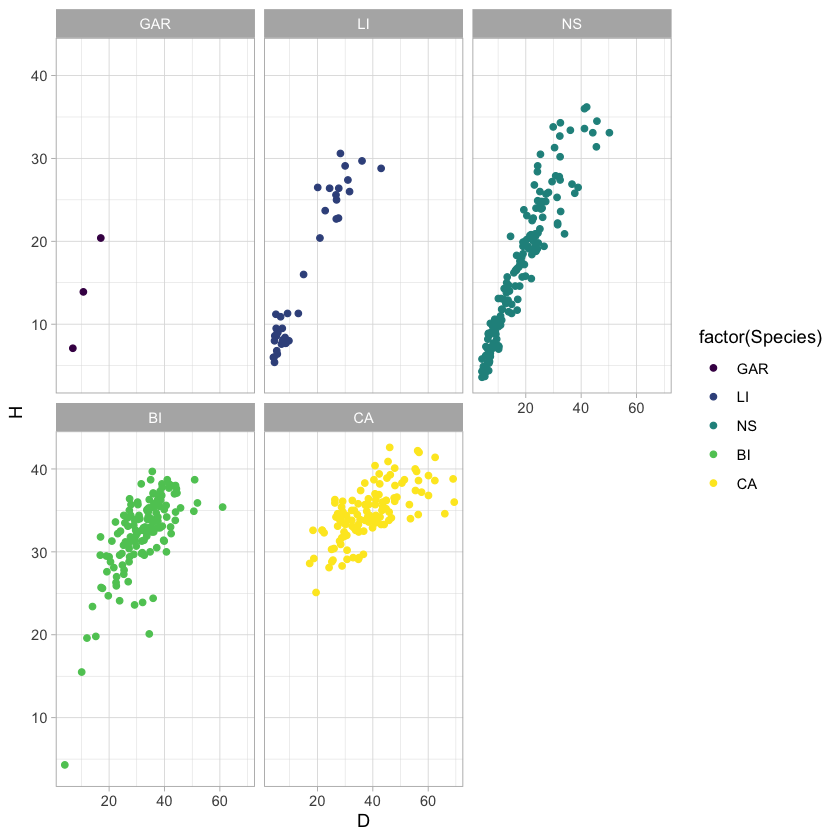

In [28]:
# Visualisation of the data used in the fitting
#
ggplot(data1, aes(x = D, y = H, color = factor(Species))) +
  geom_point() +
  facet_wrap(~ Species)

In [29]:
# retrieve the coefficients of the model
#
coef(model1a)
#coef(model1b)
#coef(model1c)

,a,b,c
GAR,32.54280,0.08451189,1.898215
LI,30.37276,0.08451189,1.898215
NS,28.45671,0.08451189,1.898215
BI,36.40601,0.08451189,1.898215
CA,37.00422,0.08451189,1.898215


In [30]:
mean(coef(model1a)$a)


[1] 32.9565

In [31]:
# retrieve the coefficients of the model
#
#coef(model2ab)
coef(model2ac)
#coef(model2bc)

,a,b,c
GAR,38.42557,0.04568429,1.2041680
LI,38.42557,0.04568429,1.2787880
NS,38.42557,0.04568429,1.4660479
BI,38.42557,0.04568429,0.7514508
CA,38.42557,0.04568429,0.6476750


In [32]:
# retrieve the coefficients of the model
#
coef(model3)

,a,b,c
GAR,38.42656,0.04567644,1.2040956
LI,38.42656,0.04567644,1.2785439
NS,38.42656,0.04567644,1.4657877
BI,38.42656,0.04567644,0.7513114
CA,38.42656,0.04567644,0.6475341


In [33]:
# The nmle fitting gave us also parameter estimates for the
# Birch stand! 

In [34]:
# make a new dataframe
#
data2 <- data1

In [35]:
# add the model predictions to the new dataframe
#
data2$preda <-predict(model1a)
data2$predb <-predict(model1b)
data2$predc <-predict(model1c)
data2$pred2ab <- predict(model2ab)
data2$pred2ac <- predict(model2ac)
data2$pred2bc <- predict(model2bc)
data2$pred3 <- predict(model3)
#head(data2)

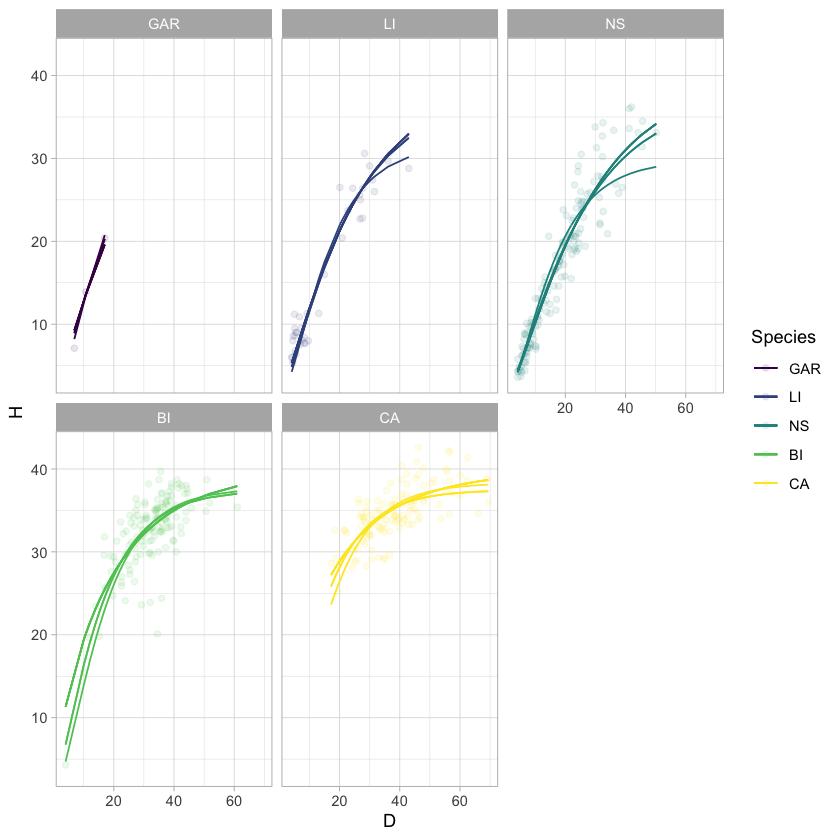

In [36]:
# plot the predicted models over the data
#
ggplot(data2, aes(x=D, y=H, color=Species))+geom_point(alpha=0.1)+geom_line(aes(y=preda))+geom_line(aes(y=predb))+geom_line(aes(y=predc))+geom_line(aes(y=pred2ab))+geom_line(aes(y=pred2ac))+geom_line(aes(y=pred2bc))+geom_line(aes(y=pred3))+facet_wrap(~Species)

In [37]:
fun.1a <- function(x) 1.3 + summary(model1a)$tTable[1,1] * (1 - exp(-summary(model1a)$tTable[2,1] * x))^summary(model1a)$tTable[3,1]
fun.1b <- function(x) 1.3 + summary(model1b)$tTable[1,1] * (1 - exp(-summary(model1b)$tTable[2,1] * x))^summary(model1b)$tTable[3,1]
fun.1c <- function(x) 1.3 + summary(model1c)$tTable[1,1] * (1 - exp(-summary(model1c)$tTable[2,1] * x))^summary(model1c)$tTable[3,1]

fun.2ab <- function(x) 1.3 + summary(model2ab)$tTable[1,1] * (1 - exp(-summary(model2ab)$tTable[2,1] * x))^summary(model2ab)$tTable[3,1]
fun.2ac <- function(x) 1.3 + summary(model2ac)$tTable[1,1] * (1 - exp(-summary(model2ac)$tTable[2,1] * x))^summary(model2ac)$tTable[3,1]
fun.2bc <- function(x) 1.3 + summary(model2bc)$tTable[1,1] * (1 - exp(-summary(model2bc)$tTable[2,1] * x))^summary(model2bc)$tTable[3,1]

fun.3 <- function(x) 1.3 + summary(model3)$tTable[1,1] * (1 - exp(-summary(model3)$tTable[2,1] * x))^summary(model3)$tTable[3,1]

In [38]:
# function to place a common legend for ggplots arranged in a grid

library(ggplot2)
library(gridExtra)
library(grid)

grid_arrange_shared_legend <- function(..., nrow = 1, ncol = length(list(...)), position = c("bottom", "right")) {

  plots <- list(...)
  position <- match.arg(position)
  g <- ggplotGrob(plots[[1]] + theme(legend.position = position))$grobs
  legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
  lheight <- sum(legend$height)
  lwidth <- sum(legend$width)
  gl <- lapply(plots, function(x) x + theme(legend.position = "none"))
  gl <- c(gl, nrow = nrow, ncol = ncol)

  combined <- switch(position,
                     "bottom" = arrangeGrob(do.call(arrangeGrob, gl),
                                            legend,
                                            ncol = 1,
                                            heights = unit.c(unit(1, "npc") - lheight, lheight)),
                     "right" = arrangeGrob(do.call(arrangeGrob, gl),
                                           legend,
                                           ncol = 2,
                                           widths = unit.c(unit(1, "npc") - lwidth, lwidth)))
  grid.newpage()
  grid.draw(combined)

}


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [39]:
df1 <- data2[, c("Species","H","preda")]
df1$resid <- residuals(model1a)
df1$residP <- residuals(model1a, type="pearson")
#head(df1)

In [40]:
df1a <- data2[, c("Species","H","preda")]
df1a$resid <- residuals(model1a)
df1a$residP <- residuals(model1a, type="pearson")
#head(df1a)

df1b <- data2[, c("Species","H","predb")]
df1b$resid <- residuals(model1b)
df1b$residP <- residuals(model1b, type="pearson")
#head(df1b)

df1c <- data2[, c("Species","H","predc")]
df1c$resid <- residuals(model1c)
df1c$residP <- residuals(model1c, type="pearson")
#head(df1c)

df2ab <- data2[, c("Species","H","pred2ab")]
df2ab$resid <- residuals(model2ab)
df2ab$residP <- residuals(model2ab, type="pearson")
#head(df2ab)

df2ac <- data2[, c("Species","H","pred2ac")]
df2ac$resid <- residuals(model2ac)
df2ac$residP <- residuals(model2ac, type="pearson")
#head(df2ac)

df2bc <- data2[, c("Species","H","pred2bc")]
df2bc$resid <- residuals(model2bc)
df2bc$residP <- residuals(model2bc, type="pearson")
#head(df2bc)

df3 <- data2[, c("Species","H","pred3")]
df3$resid <- residuals(model3)
df3$residP <- residuals(model3, type="pearson")
#head(df3)

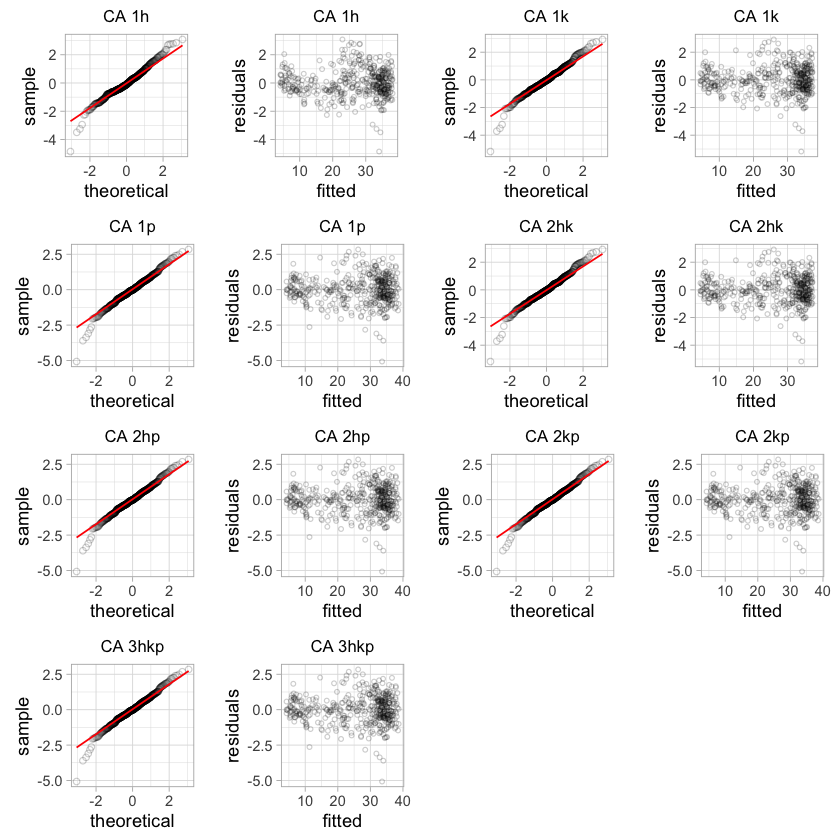

In [41]:
library(gridExtra) 
#pdf("ja_cha_qqfit.pdf")
theme_set(
  theme_light() # + theme(legend.position = "top")
  )
theme_update(plot.title = element_text(hjust = 0.5, size=10))

g = grid.arrange(
ggplot(df1a, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 1h") + theme(aspect.ratio=1),
ggplot(df1a, aes(preda,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 1h") + theme(aspect.ratio=1),    

ggplot(df1b, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 1k") + theme(aspect.ratio=1),
ggplot(df1b, aes(predb,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 1k") + theme(aspect.ratio=1),   

ggplot(df1c, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 1p") + theme(aspect.ratio=1),
ggplot(df1c, aes(predc,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 1p") + theme(aspect.ratio=1),  

ggplot(df2ab, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 2hk") + theme(aspect.ratio=1),
ggplot(df2ab, aes(pred2ab,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 2hk") + theme(aspect.ratio=1),  

ggplot(df2ac, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 2hp") + theme(aspect.ratio=1),
ggplot(df2ac, aes(pred2ac,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 2hp") + theme(aspect.ratio=1),  
    
ggplot(df2bc, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 2kp") + theme(aspect.ratio=1),
ggplot(df2bc, aes(pred2bc,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 2kp") + theme(aspect.ratio=1),  

ggplot(df3, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 3hkp") + theme(aspect.ratio=1),
ggplot(df3, aes(pred3,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 3hkp") + theme(aspect.ratio=1), 
    
nrow=4,ncol=4)
#dev.off()

In [42]:
# Create plots for article 

In [43]:
plca1a <- ggplot(data2, aes(x=D, y=H, color=Species))+geom_point(alpha=0.3)+ geom_line(aes(y=preda))+annotate("text", x = 80, y = 10, label = "CA 1h")+ stat_function(geom="line", fun = fun.1a, colour="red") + xlim(0,100) + theme(aspect.ratio=1)+ labs(x="Tree diameter at 1.3 m (cm)", y = "Tree height (m)") + theme(text = element_text(size=10))

plca2ac <- ggplot(data2, aes(x=D, y=H, color=Species))+geom_point(alpha=0.3)+ geom_line(aes(y=pred2ac))+annotate("text", x = 80, y = 10, label = "CA 2hp")+ stat_function(geom="line", fun = fun.2ac, colour="red") + xlim(0,100) + theme(aspect.ratio=1)+ labs(x="Tree diameter at 1.3 m (cm)", y = "Tree height (m)") + theme(text = element_text(size=10))

plca3abc <- ggplot(data2, aes(x=D, y=H, color=Species))+geom_point(alpha=0.3)+ geom_line(aes(y=pred3))+annotate("text", x = 80, y = 10, label = "CA 3hkp")+ stat_function(geom="line", fun = fun.3, colour="red") + xlim(0,100) + theme(aspect.ratio=1)+ labs(x="Tree diameter at 1.3 m (cm)", y = "Tree height (m)") + theme(text = element_text(size=10))

plca1aqq <- ggplot(df1a, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 1h") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))

plca1are <- ggplot(df1a, aes(preda,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 1h") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))    

plca2acqq <- ggplot(df2ac, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 2hp") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))

plca2acre <- ggplot(df2ac, aes(pred2ac,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 2hp") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))  

plca3abcqq <- ggplot(df3, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("CA 3hkp") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))

plca3abcre <- ggplot(df3, aes(pred3,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("CA 3hkp") + theme(aspect.ratio=1)+ theme(text = element_text(size=10)) 
    



## Näslund model

here the model 

$$
H = 1.3 + (\frac{D}{a + b D}) \quad \textrm{with} \quad b = \sqrt[3]{\frac{1}{h_{mx} - 1.3}}
$$

is defined. The rescaling for $b$ let the height parameter be comparable to the Chapman's model.

In [44]:
###############################################################################################################
#
# Here starts the Näslund modeling part 
# 
###############################################################################################################

In [45]:
# Reparameterisation for b

# b := (1/(asymH - 1.3))^(1/3) 

In [46]:
# here I set up a fixed effects model (chapman with free intercept)
#
fm2 = nlsList(H ~ 1.3 + (D / (a + (1/(b - 1.3))^(1/3) * D))^3, data=data1, start=list(a=1., b=40.))

In [47]:
fm2

Call:
  Model: H ~ 1.3 + (D/(a + (1/(b - 1.3))^(1/3) * D))^3 | Species 
   Data: data1 

Coefficients:
            a        b
GAR 1.9047707 57.83468
LI  1.5304613 42.50019
NS  2.2048908 53.07569
BI  1.0475164 45.18692
CA  0.8596159 43.72973

Degrees of freedom: 459 total; 449 residual
Residual standard error: 2.674999

In [48]:
summary(fm2)

Call:
  Model: H ~ 1.3 + (D/(a + (1/(b - 1.3))^(1/3) * D))^3 | Species 
   Data: data1 

Coefficients:
   a 
     Estimate Std. Error   t value     Pr(>|t|)
GAR 1.9047707 0.71532749  2.662795 9.142417e-02
LI  1.5304613 0.12707273 12.043979 9.137739e-15
NS  2.2048908 0.08877941 24.835610 3.047480e-57
BI  1.0475164 0.08488338 12.340653 1.196211e-20
CA  0.8596159 0.09559555  8.992217 1.558885e-17
   b 
    Estimate Std. Error   t value     Pr(>|t|)
GAR 57.83468  33.755875  1.713322 1.407354e-01
LI  42.50019   2.601906 16.334253 7.370272e-19
NS  53.07569   2.167549 24.486497 1.774385e-56
BI  45.18692   1.273185 35.491254 2.099542e-65
CA  43.72973   1.177778 37.129010 1.553486e-72

Residual standard error: 2.674999 on 449 degrees of freedom


In [49]:
nmodel1a=nlme(fm2,data1, fixed=list(a~1,b~1,c~1), random=a~1|Species)
nmodel1b=nlme(fm2,data1, fixed=list(a~1,b~1,c~1), random=b~1|Species)

Warning message in nlme.nlsList(fm2, data1, fixed = list(a ~ 1, b ~ 1, c ~ 1), random = a ~ :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”Warning message in nlme.nlsList(fm2, data1, fixed = list(a ~ 1, b ~ 1, c ~ 1), random = b ~ :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”

### The output for the models not shown in the article is supressed

In [50]:
nmodel1a
#nmodel1b

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + (D/(a + (1/(b - 1.3))^(1/3) * D))^3 
  Data: data1 
  Log-likelihood: -1119.206
  Fixed: list(a ~ 1, b ~ 1) 
        a         b 
 1.458757 45.906010 

Random effects:
 Formula: a ~ 1 | Species
                a Residual
StdDev: 0.3528339 2.711978

Number of Observations: 459
Number of Groups: 5 

In [51]:
summary(nmodel1a)
#summary(nmodel1b)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + (D/(a + (1/(b - 1.3))^(1/3) * D))^3 
 Data: data1 
       AIC      BIC    logLik
  2246.412 2262.928 -1119.206

Random effects:
 Formula: a ~ 1 | Species
                a Residual
StdDev: 0.3528339 2.711978

Fixed effects: list(a ~ 1, b ~ 1) 
     Value Std.Error  DF  t-value p-value
a  1.45876 0.1678377 453  8.69148       0
b 45.90601 0.7870832 453 58.32422       0
 Correlation: 
  a    
b 0.237

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-5.01221061 -0.57341301 -0.06073437  0.60475703  3.07674381 

Number of Observations: 459
Number of Groups: 5 

In [52]:
nmodel2ab=nlme(fm2,data1, fixed=a + b + c ~ 1, random=pdDiag(a + b ~1), groups= ~ Species)

Warning message in nlme.nlsList(fm2, data1, fixed = a + b + c ~ 1, random = pdDiag(a + :
“'nlme.nlsList' will redefine 'fixed', 'data', and 'start'”

In [53]:
nmodel2ab

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + (D/(a + (1/(b - 1.3))^(1/3) * D))^3 
  Data: data1 
  Log-likelihood: -1116.977
  Fixed: list(a ~ 1, b ~ 1) 
        a         b 
 1.454346 46.056080 

Random effects:
 Formula: list(a ~ 1, b ~ 1)
 Level: Species
 Structure: Diagonal
                a        b Residual
StdDev: 0.4387499 2.895754 2.675606

Number of Observations: 459
Number of Groups: 5 

In [54]:
summary(nmodel2ab)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: H ~ 1.3 + (D/(a + (1/(b - 1.3))^(1/3) * D))^3 
 Data: data1 
       AIC    BIC    logLik
  2243.955 2264.6 -1116.977

Random effects:
 Formula: list(a ~ 1, b ~ 1)
 Level: Species
 Structure: Diagonal
                a        b Residual
StdDev: 0.4387499 2.895754 2.675606

Fixed effects: list(a ~ 1, b ~ 1) 
     Value Std.Error  DF   t-value p-value
a  1.45435 0.2055064 453  7.076886       0
b 46.05608 1.7015675 453 27.066855       0
 Correlation: 
  a   
b 0.13

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-5.068380856 -0.571018021  0.008339644  0.615652000  2.908857266 

Number of Observations: 459
Number of Groups: 5 

In [55]:
coef(nmodel1a)
#coef(nmodel1b)

,a,b
GAR,1.590282,45.90601
LI,1.668601,45.90601
NS,1.912508,45.90601
BI,1.094744,45.90601
CA,1.027652,45.90601


In [56]:
coef(nmodel2ab)

,a,b
GAR,1.6049971,46.04008
LI,1.5971259,44.12639
NS,2.0923689,50.27822
BI,1.0681039,45.49304
CA,0.9091327,44.34267


In [57]:
data2n <- data1

In [58]:
# add the model predictions to the new dataframe
#
data2n$preda <-predict(nmodel1a)
data2n$predb <-predict(nmodel1b)
data2n$pred2ab <- predict(nmodel2ab)
#head(data2n)

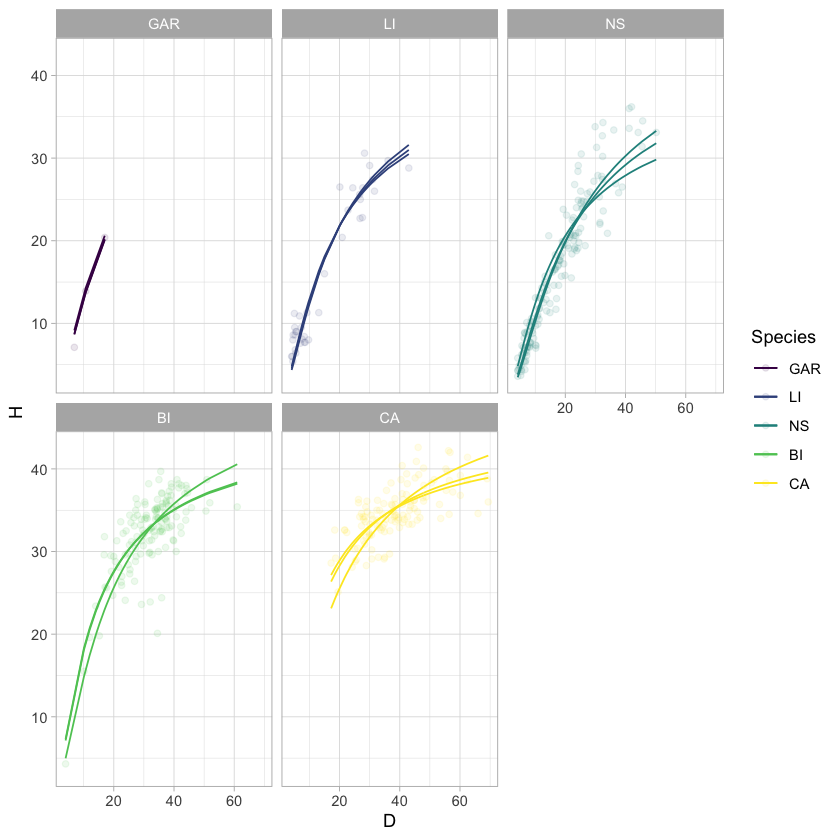

In [59]:
# plot the predicted models over the data
#
ggplot(data2n, aes(x=D, y=H, color=Species))+geom_point(alpha=0.1)+geom_line(aes(y=preda))+geom_line(aes(y=predb))+geom_line(aes(y=pred2ab))+facet_wrap(~Species)

In [60]:
nfun.1a <- function(x) 1.3 + (x / (summary(nmodel1a)$tTable[1,1] + (1/(summary(nmodel1a)$tTable[2,1] - 1.3))^(1/3) * x))^3
nfun.1b <- function(x) 1.3 + (x / (summary(nmodel1b)$tTable[1,1] + (1/(summary(nmodel1b)$tTable[2,1] - 1.3))^(1/3) * x))^3

nfun.2ab <- function(x) 1.3 + (x / (summary(nmodel2ab)$tTable[1,1] + (1/(summary(nmodel2ab)$tTable[2,1] - 1.3))^(1/3) * x))^3


In [61]:
ndf1a <- data2n[, c("Species","H","preda")]
ndf1a$resid <- residuals(nmodel1a)
ndf1a$residP <- residuals(nmodel1a, type="pearson")
#head(ndf1a)

ndf1b <- data2n[, c("Species","H","predb")]
ndf1b$resid <- residuals(nmodel1b)
ndf1b$residP <- residuals(nmodel1b, type="pearson")
#head(ndf1b)

ndf2ab <- data2n[, c("Species","H","pred2ab")]
ndf2ab$resid <- residuals(nmodel2ab)
ndf2ab$residP <- residuals(nmodel2ab, type="pearson")
#head(ndf2ab)


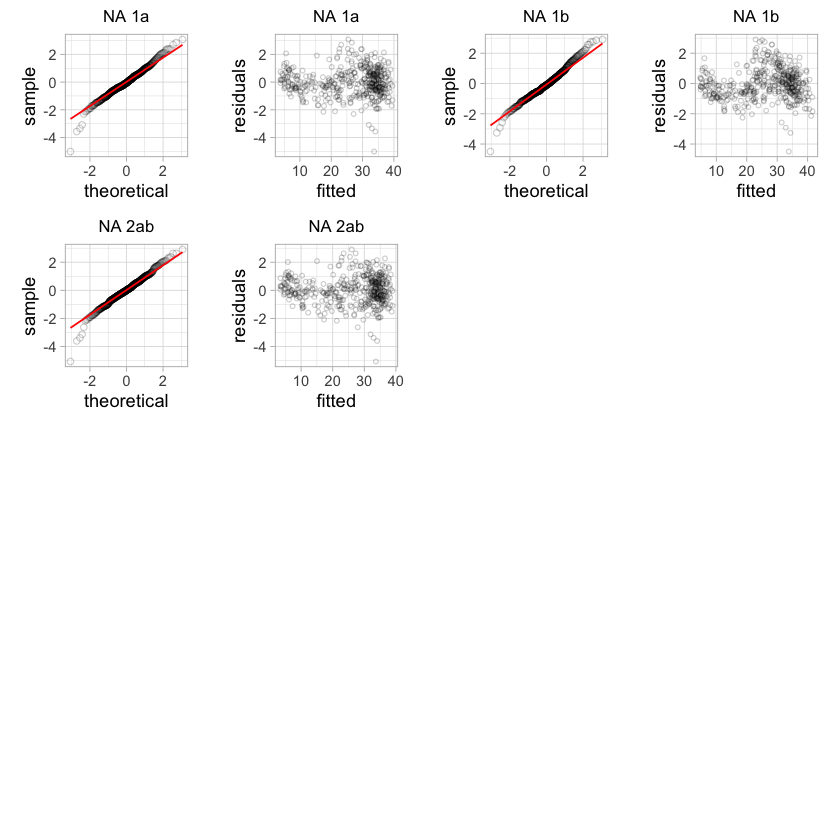

In [62]:
library(gridExtra) 
library(grid)
library(lattice)

#pdf("ja_nas_qqfitrep.pdf")
theme_set(
  theme_light() # + theme(legend.position = "top")
  )
theme_update(plot.title = element_text(hjust = 0.5, size=10))
             
g = grid.arrange(
ggplot(ndf1a, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("NA 1a") + theme(aspect.ratio=1),
ggplot(ndf1a, aes(preda,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("NA 1a") + theme(aspect.ratio=1),    

ggplot(ndf1b, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("NA 1b") + theme(aspect.ratio=1),
ggplot(ndf1b, aes(predb,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("NA 1b") + theme(aspect.ratio=1),   

ggplot(ndf2ab, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("NA 2ab") + theme(aspect.ratio=1),
ggplot(ndf2ab, aes(pred2ab,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("NA 2ab") + theme(aspect.ratio=1), 
    
nrow=4,ncol=4)
#dev.off()

In [63]:
# Create plots for the arcticle

plna1b <- ggplot(data2n, aes(x=D, y=H, color=Species))+geom_point(alpha=0.3)+ geom_line(aes(y=predb))+annotate("text", x = 80, y = 10, label = "NA 1b")+ stat_function(geom="line", fun = fun.1b, colour="red") + xlim(0,100) + theme(aspect.ratio=1)+ labs(x="Tree diameter at 1.3 m (cm)", y = "Tree height (m)") + theme(text = element_text(size=10))

plna2ab <- ggplot(data2n, aes(x=D, y=H, color=Species))+geom_point(alpha=0.3)+ geom_line(aes(y=pred2ab))+annotate("text", x = 80, y = 10, label = "NA 2ab")+ stat_function(geom="line", fun = fun.2ab, colour="red") + xlim(0,100) + theme(aspect.ratio=1)+ labs(x="Tree diameter at 1.3 m (cm)", y = "Tree height (m)") + theme(text = element_text(size=10))

plna1bqq <- ggplot(ndf1b, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("NA 1b") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))

plna1bre <- ggplot(ndf1b, aes(predb,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("NA 1b") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))   

plna2abqq <- ggplot(ndf2ab, aes(sample = residP)) + geom_qq(distribution=qnorm, shape=1, alpha=0.2) + geom_qq_line(col="Red") + ggtitle("NA 2ab") + theme(aspect.ratio=1)+ theme(text = element_text(size=10))

plna2abre <- ggplot(ndf2ab, aes(pred2ab,residP)) + geom_point(shape=1, size=1, alpha=0.2) + labs(x ="fitted", y = "residuals") + ggtitle("NA 2ab") + theme(aspect.ratio=1)+ theme(text = element_text(size=10)) 
 


### Show plots for the article

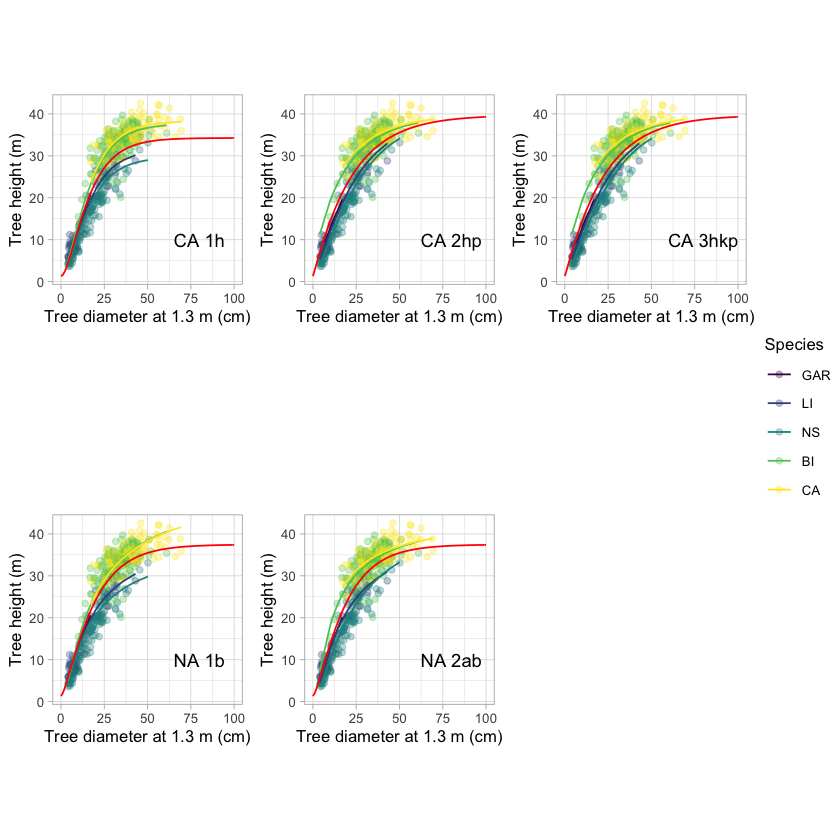

In [64]:
library(gridExtra)
#pdf("fig3.pdf")
g = grid_arrange_shared_legend(plca1a, plca2ac, plca3abc, plna1b, plna2ab,
nrow=2,ncol=3, position="right")
#dev.off()

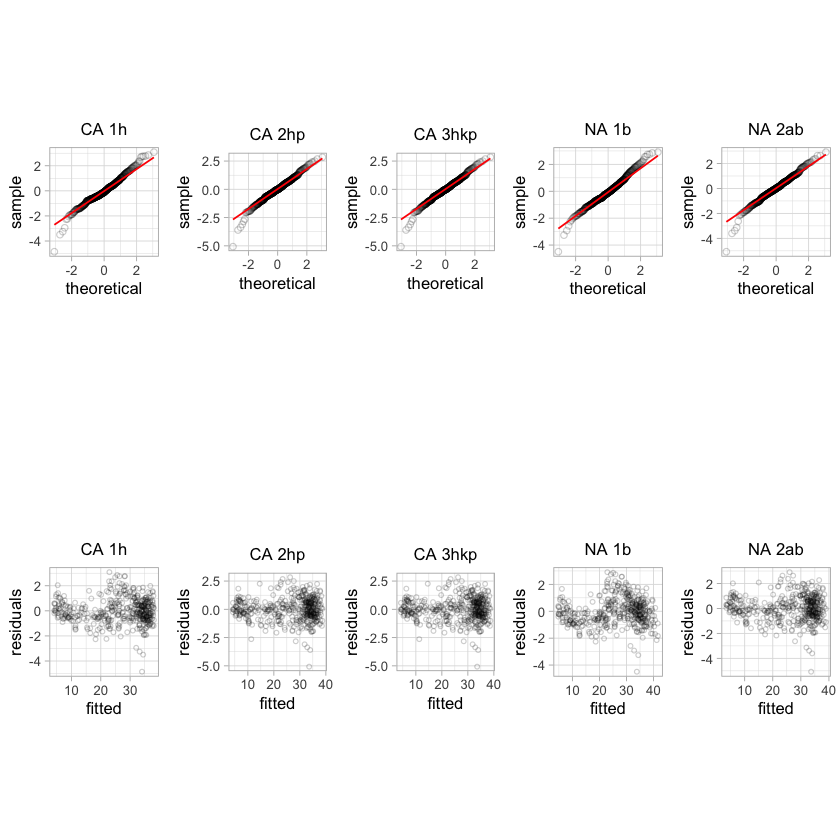

In [65]:
library(gridExtra)
#pdf("fig3aa.pdf")
g = grid.arrange(plca1aqq, plca2acqq, plca3abcqq, plna1bqq, plna2abqq, plca1are, plca2acre, plca3abcre, plna1bre, plna2abre,
nrow=2,ncol=5)
#dev.off()

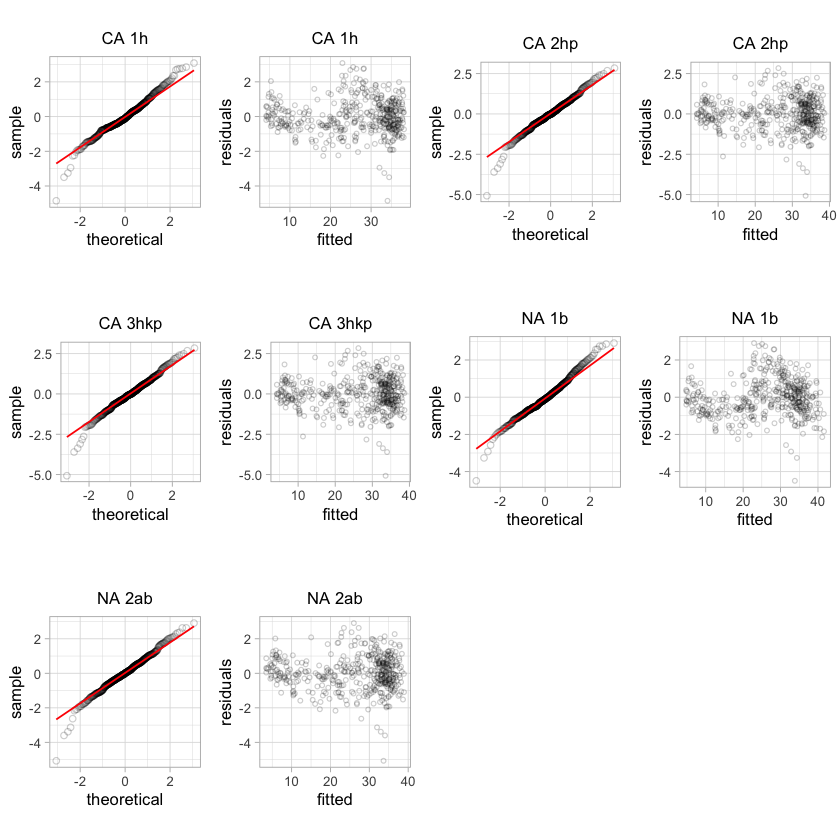

In [66]:
library(gridExtra)
#pdf("fig3aax.pdf")
g = grid.arrange(plca1aqq, plca1are, plca2acqq, plca2acre, plca3abcqq, plca3abcre, plna1bqq, plna1bre, plna2abqq, plna2abre,
nrow=3,ncol=4)
#dev.off()